In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from time import time

import patchmatch as pm

IndentationError: expected an indented block (patchmatch.py, line 250)

In [2]:
%matplotlib qt

In [3]:
%matplotlib inline

In [2]:
im = Image.open("data/TP_C01_011_copy_ln20.png")
im = np.array(im).astype("double")[400:]
gt = Image.open("data/TP_C01_011_gt_ln20.png")
gt = np.array(gt)[400:] > 0

In [3]:
a = pm.PatchMatch(im, p=10, T=100, N=1, L=3)

### Analyze patches

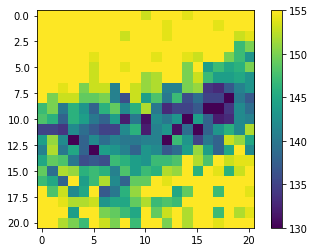

In [6]:
plt.imshow(a.patch(234, 55)[..., 0], vmin=130, vmax=155)
plt.colorbar()

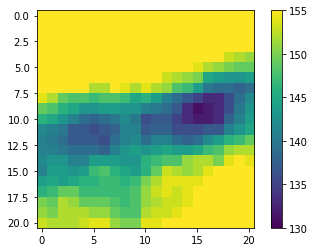

In [7]:
plt.imshow(a.patch(266, 544)[..., 0], vmin=130, vmax=155)
plt.colorbar()

### Scan image

In [1]:
a.im.shape

NameError: name 'a' is not defined

In [4]:
a.iterate()

Scan


ValueError: operands could not be broadcast together with shapes (21,21,3) (0,21,3) 

### After 2 scan

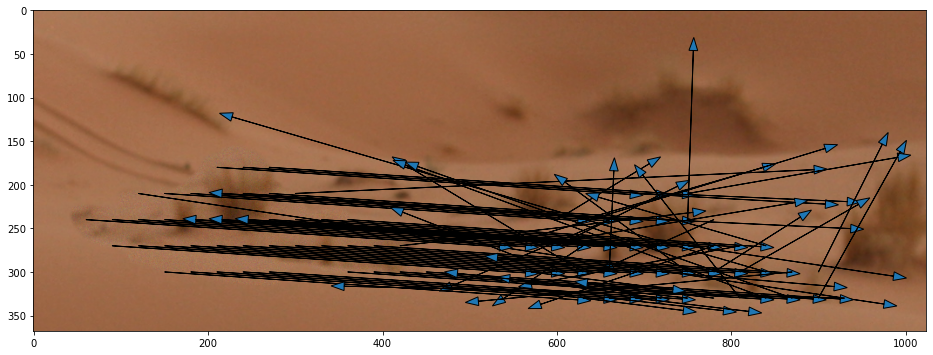

In [18]:
plt.figure(figsize=(16,6))
pm.plot_vect_field(a, gt, step=30, head_width=10)

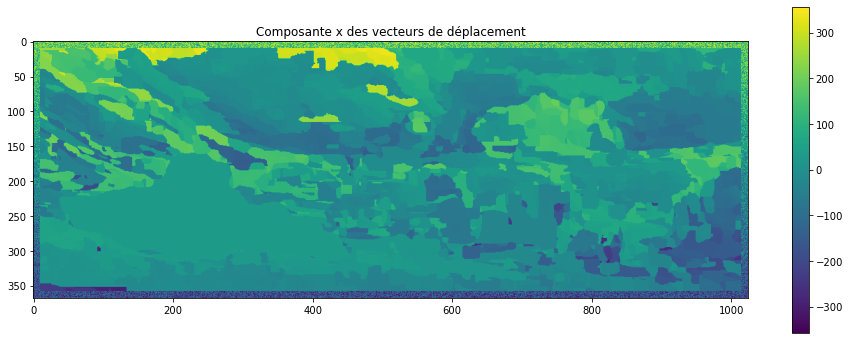

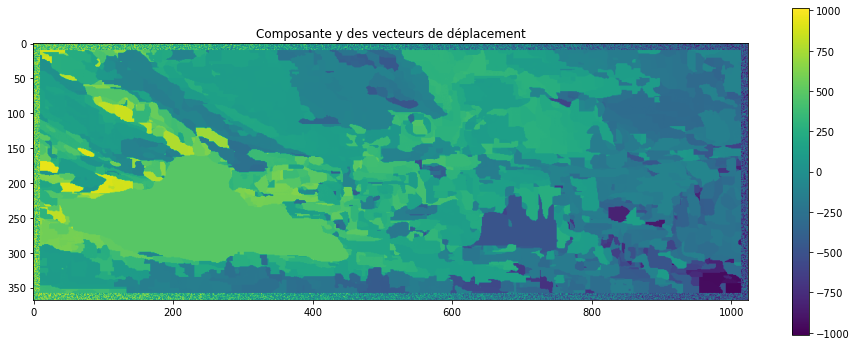

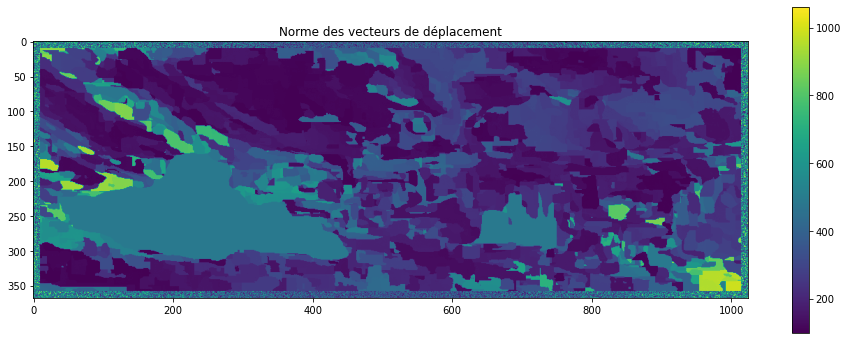

In [26]:
plt.figure(figsize=(16,6))
plt.title('Composante x des vecteurs de déplacement')
plt.imshow(a.vect_field[..., 0]) #, vmin=0, vmax=60)
plt.colorbar()
plt.show()
plt.figure(figsize=(16,6))
plt.title('Composante y des vecteurs de déplacement')
plt.imshow(a.vect_field[..., 1]) #, vmin=0, vmax=60)
plt.colorbar()
plt.show()
plt.figure(figsize=(16,6))
plt.title('Norme des vecteurs de déplacement')
plt.imshow(np.sqrt(a.vect_field[..., 0]**2 + a.vect_field[..., 1]**2)) #, vmin=0, vmax=60)
plt.colorbar()
plt.show()

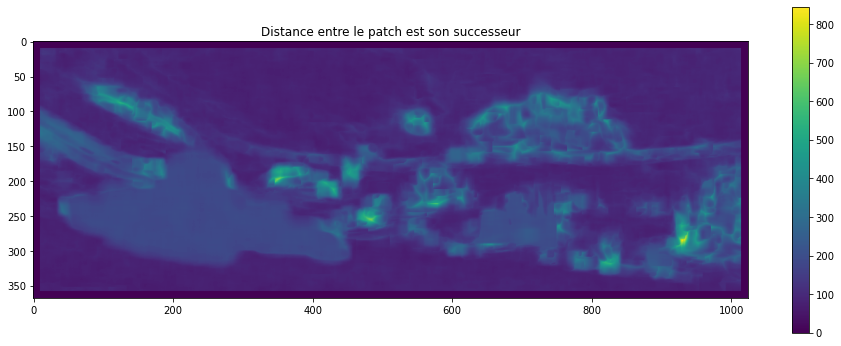

In [29]:
plt.figure(figsize=(16,6))
plt.title('Distance entre le patch est son successeur')
plt.imshow(a.dist_field)
plt.colorbar()
plt.show()

### After more scan

In [8]:
a.run()

617143
497724
387995
309161
243903
196108
159508
132476
113208
96584
83325
72863
65199
58779
53380
48931
45110
41425
38619
35398


In [9]:
Cnt = [617143,497724,387995,309161,243903,196108,159508,132476,113208,96584,83325,72863,65199,58779,53380,48931,45110,41425,38619,35398]

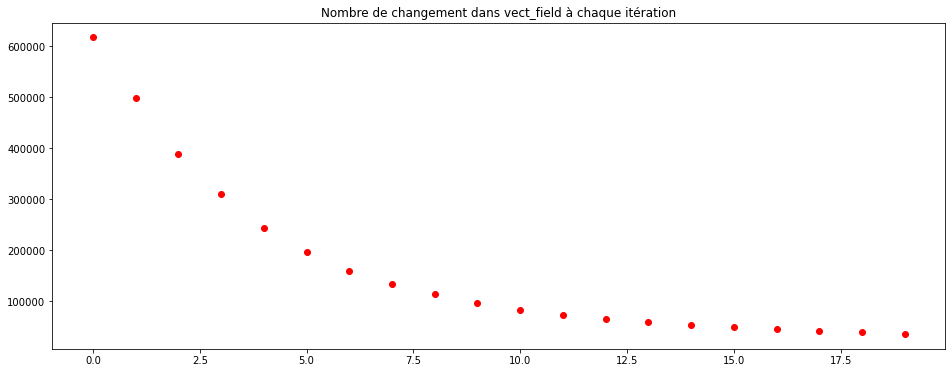

In [13]:
plt.figure(figsize=(16,6))
plt.title('Nombre de changement dans vect_field à chaque itération')
plt.plot(Cnt,'ro')
plt.show()

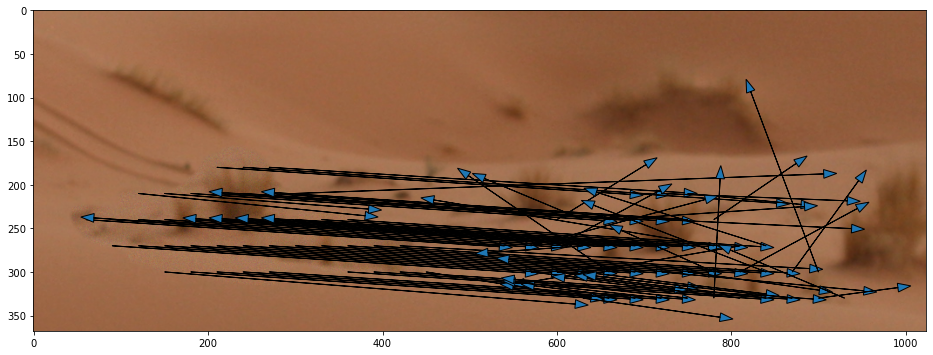

In [14]:
plt.figure(figsize=(16,6))
pm.plot_vect_field(a, gt, step=30, head_width=10)

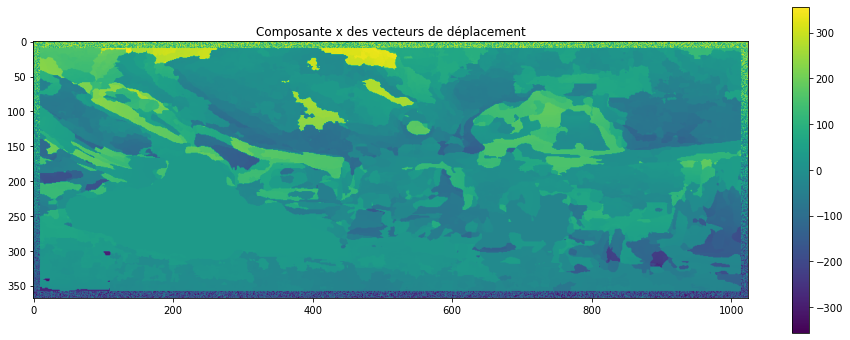

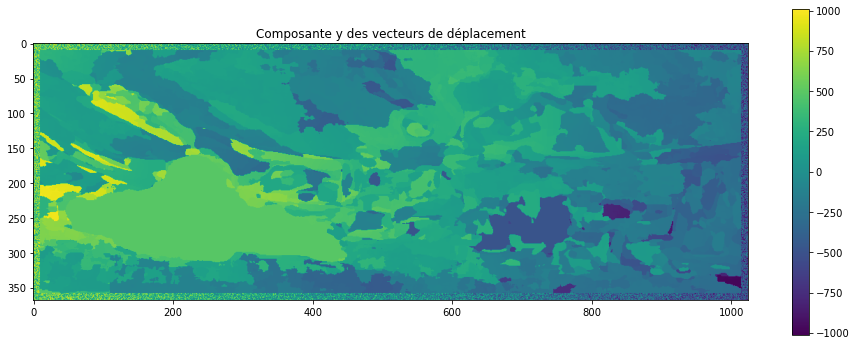

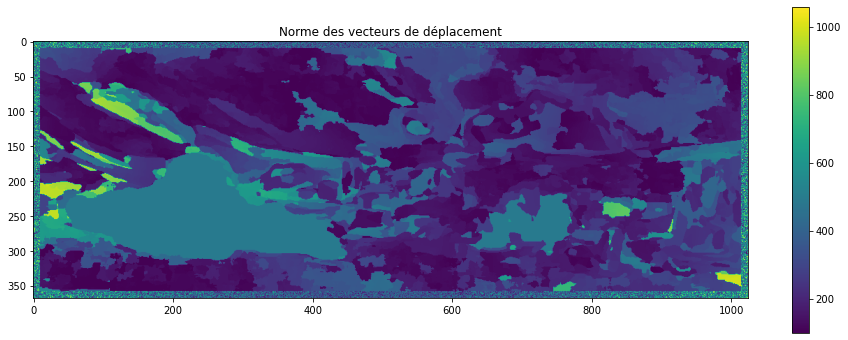

In [15]:
plt.figure(figsize=(16,6))
plt.title('Composante x des vecteurs de déplacement')
plt.imshow(a.vect_field[..., 0]) #, vmin=0, vmax=60)
plt.colorbar()
plt.show()
plt.figure(figsize=(16,6))
plt.title('Composante y des vecteurs de déplacement')
plt.imshow(a.vect_field[..., 1]) #, vmin=0, vmax=60)
plt.colorbar()
plt.show()
plt.figure(figsize=(16,6))
plt.title('Norme des vecteurs de déplacement')
plt.imshow(np.sqrt(a.vect_field[..., 0]**2 + a.vect_field[..., 1]**2)) #, vmin=0, vmax=60)
plt.colorbar()
plt.show()

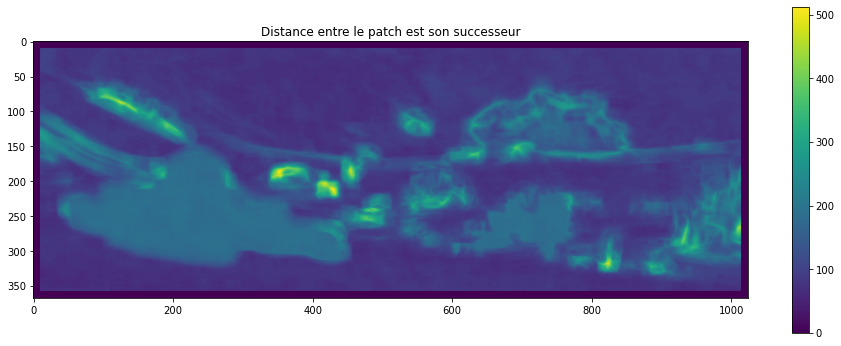

In [16]:
plt.figure(figsize=(16,6))
plt.title('Distance entre le patch est son successeur')
plt.imshow(a.dist_field)
plt.colorbar()
plt.show()

In [27]:
# a = pm.PatchMatch(im, T=100, p=3, N=0, L=1)
# t0 = time()
# v = a.run()
# t1 = time()
# print("Execution time:", t1 - t0)
# a = pm.PatchMatch(im, T=100, p=3, N=10, L=1)
# t0 = time()
# v = a.run()
# t1 = time()
# print("Execution time:", t1 - t0)